## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)


# Setup

## Import modules

In [1]:
# ignore deprication warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


# standard modules
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, colors
# work in interactive moode
%matplotlib inline 


# loading files (in parallel)
from pathlib import Path
from multiprocessing.pool import ThreadPool


# working with images
import PIL
from PIL import Image
from skimage import io

# preprocessing
from sklearn.preprocessing import LabelEncoder


# torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
# torchvision
import torchvision
from torchvision import transforms


# interacrive timimg
from tqdm import tqdm, tqdm_notebook

# saving models 
import pickle
import copy

In [2]:
print(PIL.__version__)

7.2.0


In [3]:
print("torch.__version__ :", torch.__version__)
print("torchvision.__version__ :", torchvision.__version__)

torch.__version__ : 1.5.1
torchvision.__version__ : 0.6.0a0+35d732a


## Choose training device

In [4]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


* ## Set device, 

In [5]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
DEVICE

device(type='cuda')

In [7]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Preparing the Data

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:

$input = \frac{input - \mu}{\text{standard deviation}} $,

константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

## Class for loading the data from folders in parallel

In [8]:
class SimpsonsDataset(Dataset):
    """
    Class to work with image dastaset, which
    - loads them form the folders in parallel
    - converts to PyTorch tensors
    - scales the tensors to have mean = 0, standard deviation = 1
    """
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files) # list of files to be loaded
        self.mode = mode           # working mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                
    
    def __len__(self):
        return self.len_
    
    
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
    
    
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)
    
    
    def __getitem__(self, index):
        # converts to PyTorch tensors and normalises the input
        
        data_transforms = {
            'train': transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomRotation(degrees=30),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(hue=.1, saturation=.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ]),
            'val_test': transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ]),
        }

        transform = (data_transforms['train'] if self.mode == 'train' else data_transforms['val_test'])
        
        x = self.load_sample(self.files[index])  # load image
        x = transform(x)                         # apply transform defined above
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

## Get training filenames and labels

In [10]:
# Uncomment to check the directories

# %ls ../input/journey-springfield/testset/testset/
# %ls ../input/journey-springfield/train/simpsons_dataset/

In [11]:
TRAIN_DIR = Path('../input/journey-springfield/train/simpsons_dataset/')
TEST_DIR = Path('../input/journey-springfield/testset/testset/')

train_val_files = sorted(list(TRAIN_DIR.rglob('*/*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [12]:
print(len(train_val_files), 'train files')
train_val_files[:5]

20933 train files


[PosixPath('../input/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg'),
 PosixPath('../input/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0001.jpg'),
 PosixPath('../input/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0002.jpg'),
 PosixPath('../input/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0003.jpg'),
 PosixPath('../input/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0004.jpg')]

In [13]:
print(len(test_files), 'test files')
test_files[:5]

991 test files


[PosixPath('../input/journey-springfield/testset/testset/img0.jpg'),
 PosixPath('../input/journey-springfield/testset/testset/img1.jpg'),
 PosixPath('../input/journey-springfield/testset/testset/img10.jpg'),
 PosixPath('../input/journey-springfield/testset/testset/img100.jpg'),
 PosixPath('../input/journey-springfield/testset/testset/img101.jpg')]

In [14]:
# path.parent.name returns a folder in which the image is, which corresponds to the label in nthis case
train_val_labels = [path.parent.name for path in train_val_files]

In [15]:
print(len(train_val_labels), 'train_val_labels')
train_val_labels[:5]

20933 train_val_labels


['abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson']

# Training

## Train-Validation split

In [16]:
from sklearn.model_selection import train_test_split
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

## Validation dataset

In [17]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Let's have a look at the characters in the validation dataset

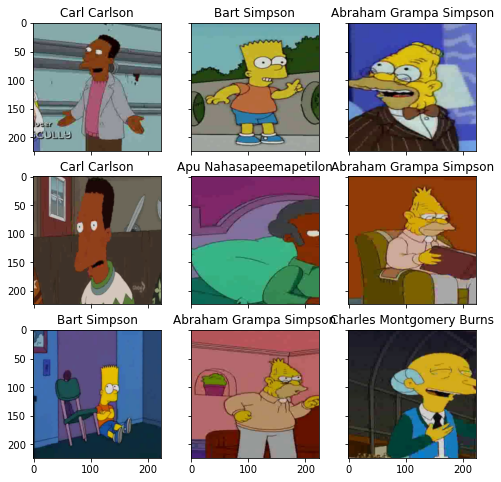

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# Functions for training

In [19]:
def fit_epoch(model, train_loader, criterion, optimizer):
    # initialize tracked variables
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # reset the gradient
        optimizer.zero_grad()
        
        # predictions (probabilities), loss, backprop
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # weights update
        optimizer.step()
        
        # predictions (classes)
        preds = torch.argmax(outputs, 1)
        
        # record tracked items
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        
    # record train loss and train accuracy          
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [20]:
def eval_epoch(model, val_loader, criterion):
    # set model model into the evaluation mode (e.g. for Dropout)
    model.eval()
    
    # initialize tracked variables
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
        
        # record tracked items
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        
    # record val loss and val accuracy
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [21]:
def train(train_dataset, val_dataset, model, criterion,
          epochs, batch_size, optimizer, scheduler,
          shuffle=True, sampler=None):
    
    # note: 4 workers loading the data
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, sampler=sampler, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            print(f"epoch {epoch+1}:\n")
            
            print("Fitting on train data...")
            # all arguments except train loader are from parameters passed to train() arguments
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("train loss:", train_loss)
            
            print("Evaluating on validation data...")
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            print("val loss:", train_loss)
            
            # record history
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            # update learning rate for the optimizer
            scheduler.step()
            
            # display learning status
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [22]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

# Training: fine-tuning pretrained resnet18

In [23]:
N_CLASSES = len(np.unique(train_val_labels))

In [24]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

## Training only the last layer

In [25]:
model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, N_CLASSES)

# to GPU
model = model.to(DEVICE)

# loss
criterion = nn.CrossEntropyLoss()

# learning rate optimizer
optimizer = torch.optim.AdamW(model.parameters())

# scheduler for the lr optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, 0.5)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [26]:
model.fc

Linear(in_features=512, out_features=42, bias=True)

In [27]:
history_feature_extr = train(train_dataset, val_dataset, model=model, criterion=criterion,
                             epochs=3, batch_size=256, optimizer=optimizer, scheduler=scheduler)

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

epoch 1:

Fitting on train data...
train loss: 2.8817217620484152
Evaluating on validation data...


epoch:  33%|███▎      | 1/3 [02:31<05:02, 151.06s/it]

val loss: 2.8817217620484152

Epoch 001 train_loss: 2.8817     val_loss 2.4494 train_acc 0.2182 val_acc 0.3919
epoch 2:

Fitting on train data...
train loss: 2.269652633372671
Evaluating on validation data...


epoch:  67%|██████▋   | 2/3 [04:56<02:29, 149.48s/it]

val loss: 2.269652633372671

Epoch 002 train_loss: 2.2697     val_loss 2.0336 train_acc 0.4384 val_acc 0.5130
epoch 3:

Fitting on train data...
train loss: 1.964561541146234
Evaluating on validation data...


epoch: 100%|██████████| 3/3 [07:23<00:00, 147.82s/it]

val loss: 1.964561541146234

Epoch 003 train_loss: 1.9646     val_loss 1.8096 train_acc 0.5135 val_acc 0.5573


Plot learning curves

In [28]:
loss, acc, val_loss, val_acc = zip(*history_feature_extr)

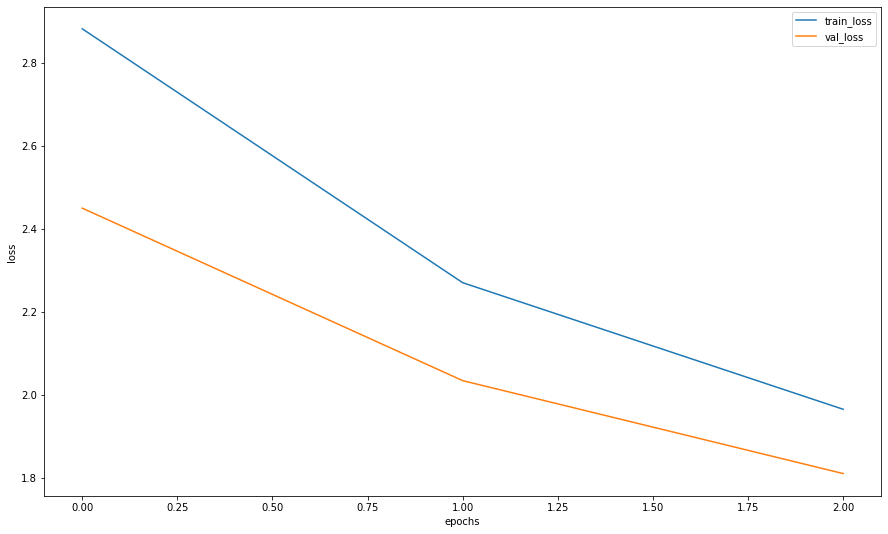

In [29]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Training all layers

In [30]:
for param in model.parameters():
    param.requires_grad = True

In [31]:
history_fine_tune = train(train_dataset=train_dataset, val_dataset=val_dataset, model=model, criterion=criterion,
                          epochs=25, batch_size=128, optimizer=optimizer, scheduler=scheduler)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

epoch 1:

Fitting on train data...
train loss: 3.3249971831070404
Evaluating on validation data...


epoch:   4%|▍         | 1/25 [02:30<1:00:15, 150.65s/it]

val loss: 3.3249971831070404

Epoch 001 train_loss: 3.3250     val_loss 3.1116 train_acc 0.1014 val_acc 0.1074
epoch 2:

Fitting on train data...
train loss: 3.10160956078103
Evaluating on validation data...


epoch:   8%|▊         | 2/25 [05:02<57:51, 150.92s/it]

val loss: 3.10160956078103

Epoch 002 train_loss: 3.1016     val_loss 3.0481 train_acc 0.1073 val_acc 0.1079
epoch 3:

Fitting on train data...
train loss: 2.956985875477236
Evaluating on validation data...


epoch:  12%|█▏        | 3/25 [07:33<55:20, 150.92s/it]

val loss: 2.956985875477236

Epoch 003 train_loss: 2.9570     val_loss 2.8263 train_acc 0.1501 val_acc 0.1825
epoch 4:

Fitting on train data...
train loss: 2.496788539934465
Evaluating on validation data...


epoch:  16%|█▌        | 4/25 [10:04<52:53, 151.10s/it]

val loss: 2.496788539934465

Epoch 004 train_loss: 2.4968     val_loss 2.1063 train_acc 0.2799 val_acc 0.3993
epoch 5:

Fitting on train data...
train loss: 1.9026732680994853
Evaluating on validation data...


epoch:  20%|██        | 5/25 [12:35<50:22, 151.12s/it]

val loss: 1.9026732680994853

Epoch 005 train_loss: 1.9027     val_loss 1.5489 train_acc 0.4679 val_acc 0.6039
epoch 6:

Fitting on train data...
train loss: 1.3134185366436466
Evaluating on validation data...


epoch:  24%|██▍       | 6/25 [15:07<47:53, 151.22s/it]

val loss: 1.3134185366436466

Epoch 006 train_loss: 1.3134     val_loss 1.0349 train_acc 0.6520 val_acc 0.7352
epoch 7:

Fitting on train data...
train loss: 0.8698749571660878
Evaluating on validation data...


epoch:  28%|██▊       | 7/25 [17:39<45:24, 151.38s/it]

val loss: 0.8698749571660878

Epoch 007 train_loss: 0.8699     val_loss 0.8350 train_acc 0.7678 val_acc 0.7912
epoch 8:

Fitting on train data...
train loss: 0.7410656207875466
Evaluating on validation data...


epoch:  32%|███▏      | 8/25 [20:11<42:57, 151.64s/it]

val loss: 0.7410656207875466

Epoch 008 train_loss: 0.7411     val_loss 0.6225 train_acc 0.8002 val_acc 0.8347
epoch 9:

Fitting on train data...
train loss: 0.6281116252583647
Evaluating on validation data...


epoch:  36%|███▌      | 9/25 [22:43<40:30, 151.88s/it]

val loss: 0.6281116252583647

Epoch 009 train_loss: 0.6281     val_loss 0.5744 train_acc 0.8289 val_acc 0.8550
epoch 10:

Fitting on train data...
train loss: 0.5029041901429191
Evaluating on validation data...


epoch:  40%|████      | 10/25 [25:14<37:53, 151.56s/it]

val loss: 0.5029041901429191

Epoch 010 train_loss: 0.5029     val_loss 0.4866 train_acc 0.8625 val_acc 0.8710
epoch 11:

Fitting on train data...
train loss: 0.4657437714036616
Evaluating on validation data...


epoch:  44%|████▍     | 11/25 [27:49<35:35, 152.52s/it]

val loss: 0.4657437714036616

Epoch 011 train_loss: 0.4657     val_loss 0.4340 train_acc 0.8720 val_acc 0.8884
epoch 12:

Fitting on train data...
train loss: 0.42690998711808636
Evaluating on validation data...


epoch:  48%|████▊     | 12/25 [30:22<33:04, 152.68s/it]

val loss: 0.42690998711808636

Epoch 012 train_loss: 0.4269     val_loss 0.4413 train_acc 0.8833 val_acc 0.8875
epoch 13:

Fitting on train data...
train loss: 0.3661585043828892
Evaluating on validation data...


epoch:  52%|█████▏    | 13/25 [32:56<30:36, 153.05s/it]

val loss: 0.3661585043828892

Epoch 013 train_loss: 0.3662     val_loss 0.3801 train_acc 0.9005 val_acc 0.9050
epoch 14:

Fitting on train data...
train loss: 0.33935313879080553
Evaluating on validation data...


epoch:  56%|█████▌    | 14/25 [35:29<28:02, 152.99s/it]

val loss: 0.33935313879080553

Epoch 014 train_loss: 0.3394     val_loss 0.3835 train_acc 0.9053 val_acc 0.9022
epoch 15:

Fitting on train data...
train loss: 0.32345907862144363
Evaluating on validation data...


epoch:  60%|██████    | 15/25 [38:01<25:27, 152.72s/it]

val loss: 0.32345907862144363

Epoch 015 train_loss: 0.3235     val_loss 0.3557 train_acc 0.9112 val_acc 0.9075
epoch 16:

Fitting on train data...
train loss: 0.29083804955633746
Evaluating on validation data...


epoch:  64%|██████▍   | 16/25 [40:31<22:46, 151.89s/it]

val loss: 0.29083804955633746

Epoch 016 train_loss: 0.2908     val_loss 0.3514 train_acc 0.9198 val_acc 0.9104
epoch 17:

Fitting on train data...
train loss: 0.28069294819490753
Evaluating on validation data...


epoch:  68%|██████▊   | 17/25 [43:03<20:15, 151.90s/it]

val loss: 0.28069294819490753

Epoch 017 train_loss: 0.2807     val_loss 0.3482 train_acc 0.9245 val_acc 0.9113
epoch 18:

Fitting on train data...
train loss: 0.27904832742325675
Evaluating on validation data...


epoch:  72%|███████▏  | 18/25 [45:33<17:40, 151.51s/it]

val loss: 0.27904832742325675

Epoch 018 train_loss: 0.2790     val_loss 0.3483 train_acc 0.9228 val_acc 0.9125
epoch 19:

Fitting on train data...
train loss: 0.2594585778515949
Evaluating on validation data...


epoch:  76%|███████▌  | 19/25 [48:05<15:09, 151.60s/it]

val loss: 0.2594585778515949

Epoch 019 train_loss: 0.2595     val_loss 0.3334 train_acc 0.9278 val_acc 0.9171
epoch 20:

Fitting on train data...
train loss: 0.2542882307094862
Evaluating on validation data...


epoch:  80%|████████  | 20/25 [50:35<12:35, 151.16s/it]

val loss: 0.2542882307094862

Epoch 020 train_loss: 0.2543     val_loss 0.3344 train_acc 0.9304 val_acc 0.9152
epoch 21:

Fitting on train data...
train loss: 0.2449036843211448
Evaluating on validation data...


epoch:  84%|████████▍ | 21/25 [53:06<10:04, 151.09s/it]

val loss: 0.2449036843211448

Epoch 021 train_loss: 0.2449     val_loss 0.3270 train_acc 0.9311 val_acc 0.9199
epoch 22:

Fitting on train data...
train loss: 0.2388274028400865
Evaluating on validation data...


epoch:  88%|████████▊ | 22/25 [55:41<07:36, 152.13s/it]

val loss: 0.2388274028400865

Epoch 022 train_loss: 0.2388     val_loss 0.3289 train_acc 0.9353 val_acc 0.9186
epoch 23:

Fitting on train data...
train loss: 0.23477730192578639
Evaluating on validation data...


epoch:  92%|█████████▏| 23/25 [58:11<05:03, 151.69s/it]

val loss: 0.23477730192578639

Epoch 023 train_loss: 0.2348     val_loss 0.3280 train_acc 0.9347 val_acc 0.9186
epoch 24:

Fitting on train data...
train loss: 0.23271235822302436
Evaluating on validation data...


epoch:  96%|█████████▌| 24/25 [1:00:43<02:31, 151.70s/it]

val loss: 0.23271235822302436

Epoch 024 train_loss: 0.2327     val_loss 0.3289 train_acc 0.9363 val_acc 0.9178
epoch 25:

Fitting on train data...
train loss: 0.23014651949568626
Evaluating on validation data...


epoch: 100%|██████████| 25/25 [1:03:13<00:00, 151.73s/it]

val loss: 0.23014651949568626

Epoch 025 train_loss: 0.2301     val_loss 0.3263 train_acc 0.9374 val_acc 0.9211


Plot learning curves

In [32]:
loss, acc, val_loss, val_acc = zip(*history_fine_tune)

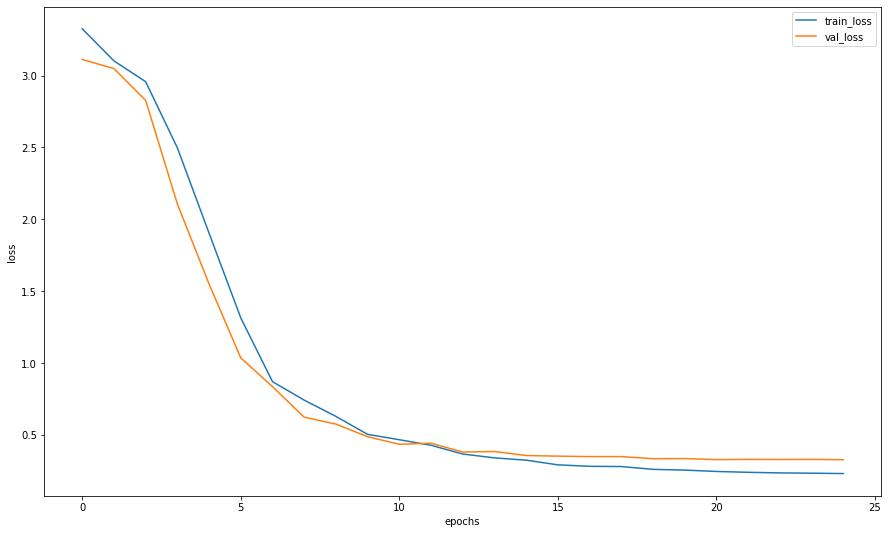

In [33]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [34]:
# save the weights of our net
model_25epoch_weights = copy.deepcopy(model.state_dict())
torch.save(model_25epoch_weights, "model_25epoch_weights.pth")

In [35]:
%ls

__notebook__.ipynb  label_encoder.pkl  model_25epoch_weights.pth


In [36]:
# загружаем сохраненное состояние весов нейросети
model.load_state_dict(torch.load("model_25epoch_weights.pth"))

<All keys matched successfully>

# What now?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [37]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [38]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [39]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

## Compare actual and predicted class ids

In [40]:
actual_labels = [val_dataset[id][1] for id in idxs]
actual_labels

[6, 2, 6, 0, 0, 0, 4, 0, 4, 2, 2, 4, 0, 5, 4, 6, 2, 6, 4, 6]

In [41]:
y_pred = np.argmax(probs_ims, -1)
y_pred

array([6, 2, 6, 0, 0, 0, 4, 0, 4, 2, 2, 4, 0, 5, 4, 6, 2, 6, 4, 6])

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе - f1-score. Вычислим целевую метрику на валидационной выборке.

In [42]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='weighted')

1.0

## Compare actual and predicted classes (strings)

In [43]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [44]:
actual_class = [label_encoder.classes_[i] for i in actual_labels]
actual_class

['charles_montgomery_burns',
 'apu_nahasapeemapetilon',
 'charles_montgomery_burns',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'bart_simpson',
 'abraham_grampa_simpson',
 'bart_simpson',
 'apu_nahasapeemapetilon',
 'apu_nahasapeemapetilon',
 'bart_simpson',
 'abraham_grampa_simpson',
 'carl_carlson',
 'bart_simpson',
 'charles_montgomery_burns',
 'apu_nahasapeemapetilon',
 'charles_montgomery_burns',
 'bart_simpson',
 'charles_montgomery_burns']

In [45]:
preds_class = [label_encoder.classes_[i] for i in y_pred]
preds_class

['charles_montgomery_burns',
 'apu_nahasapeemapetilon',
 'charles_montgomery_burns',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'bart_simpson',
 'abraham_grampa_simpson',
 'bart_simpson',
 'apu_nahasapeemapetilon',
 'apu_nahasapeemapetilon',
 'bart_simpson',
 'abraham_grampa_simpson',
 'carl_carlson',
 'bart_simpson',
 'charles_montgomery_burns',
 'apu_nahasapeemapetilon',
 'charles_montgomery_burns',
 'bart_simpson',
 'charles_montgomery_burns']

In [46]:
from sklearn.metrics import f1_score

f1_score(actual_class, preds_class, average='weighted')

1.0

Сделаем классную визуализацию, чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

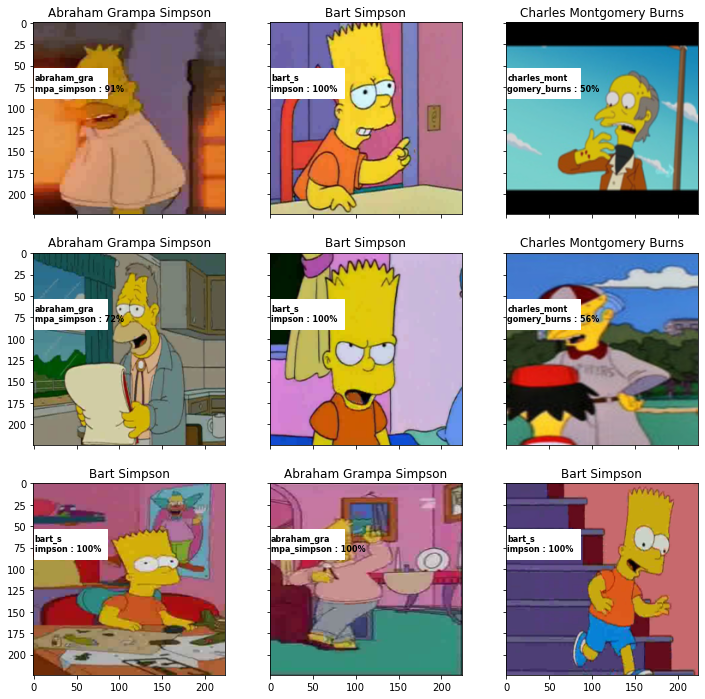

In [47]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

# Submit to Kaggle competition

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [48]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64, num_workers=4)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

# Check how the sample submission file looks

In [49]:
!ls ../input/journey-springfield

characters_illustration.png  sample_submission.csv  testset  train


In [50]:
import pandas as pd
sample_submit = pd.read_csv("../input/journey-springfield/sample_submission.csv")
sample_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [51]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
print(my_submit.shape)
my_submit.head()

(991, 2)


,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [52]:
my_submit.to_csv('resnet_submission.csv', index=False)